# Comparing rotational age with dynamical age

In [211]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import NullFormatter
import pandas as pd
from teff_bv import teff2bv
import barnes as bn
from astropy import units as u
from astropy.coordinates import SkyCoord, Galactic
import gala.dynamics as gd
import astropy.coordinates as coord
import gala.coordinates as gc

plotpar = {'axes.labelsize': 18,
           'font.size': 10,
           'legend.fontsize': 15,
           'xtick.labelsize': 18,
           'ytick.labelsize': 18,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [174]:
def match(id1, id2):
    """
    Takes two lists of ids and finds common ids.
    id1 = small
    id2 = big
    """
    matched = []
    inds1, inds2 = [], []
    for i, id in enumerate(id1):
        m = id2 == id
        if len(id2[m]):
            matched.append(id)
            inds2.append(int(np.where(m)[0]))
            inds1.append(i)
    return matched, inds1, inds2

Load catalogues

In [194]:
# load matched tgas catalogue
tgas = pd.read_csv("ruth_matched.csv")

# load Amy's catalogue
#rot = pd.read_csv("data/Table_1_Periodic.txt")

# load my catalogue
# kid, periods, localph, rvar, height = np.genfromtxt("kepler_periods.txt").T
kid, periods = np.genfromtxt("kplr_periods.txt").T

# matched, tgas_inds, rot_inds = match(tgas["kepid"], rot["KID"])
matched, tgas_inds, rot_inds = match(tgas["kepid"], kid)
print(len(matched), "Kepler-TGAS stars")

10967 Kepler-TGAS stars


In [195]:
# Create data arrays.
#p = np.array(rot["Prot"])[rot_inds]
p = np.array(periods[rot_inds])
t = np.array(tgas["teff"])[tgas_inds]
l = np.array(tgas["logg"])[tgas_inds]
f = np.array(tgas["feh"])[tgas_inds]
j = np.array(tgas["jmag"])[tgas_inds]
pmr = np.array(tgas["pmra"])[tgas_inds]
r = np.array(tgas["ra"])[tgas_inds]
pmd = np.array(tgas["pmdec"])[tgas_inds]
d = np.array(tgas["dec"])[tgas_inds]
plx = np.array(tgas["parallax"])[tgas_inds]

In [196]:
# calculate B-V color and rotation-age
b = teff2bv(t, l, f)
a = bn.age(p, b)

In [198]:
# remove giants, hot stars and bad data
m = (l > 4.35) * (t < 5800) * (t > 3800) * (plx > 0) * (periods > 0)
periods, teff, logg = p[m], t[m], l[m]
pmra, pmdec, parallax = pmr[m], pmd[m], plx[m]
jmag = j[m]
bv, age, z = b[m], a[m], zed[m]
ra, dec = r[m], d[m]
print(len(periods), "stars remaining after cuts")

285 stars remaining after cuts


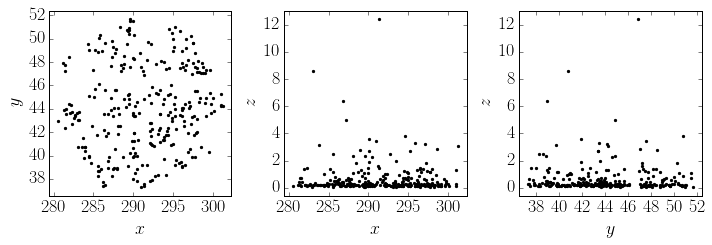

In [199]:
# calculate velocities
mas2deg = lambda x: x/60/60/1e3
w = gd.CartesianPhaseSpacePosition(pos=[ra*u.deg, dec*u.deg, (1./parallax)*u.kpc], vel=[pmra*u.mas/u.year, pmdec*u.mas/u.year, np.zeros_like(pmra)*u.kpc/u.year])
fig = w.plot()

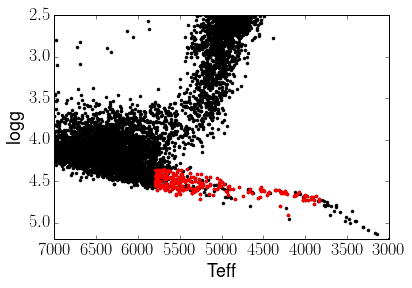

In [200]:
# plot full Kepler-TGAS HR diagram + cuts
plt.plot(t, l, "k.")
plt.xlim(7000, min(t))
plt.ylim(max(l), 2.5)
plt.plot(teff, logg, "r.")
plt.xlabel("Teff")
plt.ylabel("logg")

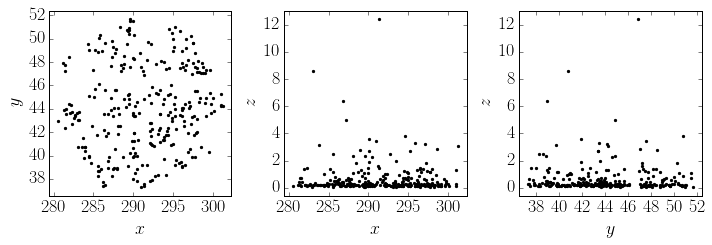

In [201]:
# replot positions
w = gd.CartesianPhaseSpacePosition(pos=[ra*u.deg, dec*u.deg, 1./parallax*u.kpc], vel=[pmra*u.mas/u.year, pmdec*u.mas/u.year, np.zeros_like(pmra)*u.kpc/u.year])
fig = w.plot()

In [217]:
def calc_dispersion(age, vz, nbins):
    # calculate dispersions
    RMS = lambda x: (np.sum(x**2)/len(x))**.5
    hist_age, bins = np.histogram(age, nbins)  # make histogram
    dispersions = []
    m = age < bins[0]
    dispersions.append(RMS(vz[m]))
    for i in range(len(bins)-1):
        m = (bins[0] < age) * (age < bins[i+1])
        if len(age[m]):
            dispersions.append(RMS(vz[m]))
    return np.array(dispersions)

Calculate Vz

In [218]:
# calculate Vz
c = coord.SkyCoord(ra=ra*u.degree, dec=dec*u.degree, 
                   distance=(parallax*u.mas).to(u.kpc, u.parallax()))
pm = np.vstack((pmra, pmdec)) * u.mas/u.yr
vxyz = gc.vhel_to_gal(c, pm=pm, rv=np.zeros(len(ra))*u.km/u.s)
xyz = c.transform_to(coord.Galactocentric).cartesian.xyz
vx, vy, vz = vxyz[0, :], vxyz[1, :], vxyz[2, :]
vz /= u.km/u.s

Apply data cuts and calculate the velocity dispersions

In [219]:
m = (age > 0.5) * (age < 12) #* ((vz**2)**.5 < 5)
age2, vz2 = age[m], vz[m]

dispersions = calc_dispersion(age2, vz2, 10)

Plot velocity dispersion as a function of age for all stars.

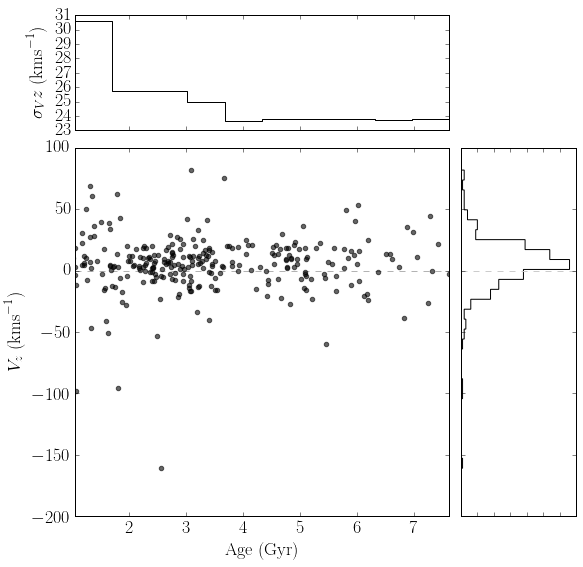

In [220]:
# scatter plot variables and settings
left, width = .1, .65
bottom, height = .1, .64
bottom_h = left_h = left + width + .02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, .2]
rect_histy = [left_h, bottom, .2, height]
plt.figure(1, figsize=(8, 8))
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
#axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

# plot scatter plot
axScatter.axhline(0, color=".7", zorder=0, linestyle="--")
axScatter.scatter(age2, vz2, marker="o", color="k", alpha=".6", zorder=1)

axScatter.set_ylabel("$V_z~(\mathrm{kms}^{-1})$")
axScatter.set_xlabel("$\mathrm{Age~(Gyr)}$")
axScatter.set_xlim(bins[0], bins[-1])

# plot histograms
#axHistx.hist(age2, histtype="stepfilled", color="w")
axHistx.step(bins, np.array(dispersions), color="k")
axHisty.hist(vz2, 30, histtype="stepfilled", color="w", orientation="horizontal")
axHisty.axhline(0, color=".8", linestyle="--")
axHistx.set_xlim(bins[0], bins[-1])
axHistx.set_ylabel("$\sigma_Vz~(\mathrm{kms}^{-1})$")

Plot a histogram of ages for low velocity stars ($V_z < 5~\mathrm{kms}^{-1}$).

69 slow stars
69 fast stars


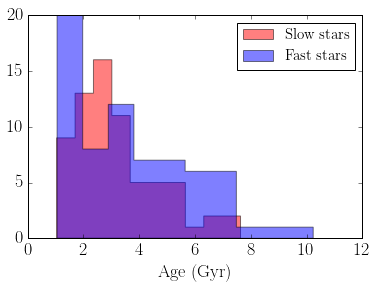

In [276]:
s = ((vz**2)**.5 < 5)  # slow stars
age2, vz2, periods2 = age[s], vz[s], periods[s]
print(len(age2), "slow stars")
plt.hist(age2, histtype="stepfilled", color="r", label="$\mathrm{Slow~stars}$", alpha=.5)

f = ((vz**2)**.5 > 20)  # fast stars
age3, vz3, periods3 = age[f], vz[f], periods[f]
print(len(age3), "fast stars")
plt.hist(age3, histtype="stepfilled", color="b", label="$\mathrm{Fast~stars}$", alpha=.5)
plt.legend()
plt.xlabel("$\mathrm{Age~(Gyr)}$")

The stars with low velocities have ages peaking at ~3 Gyr.
The stars with higher velocities have a broader range of ages.

Plot a histogram of periods.

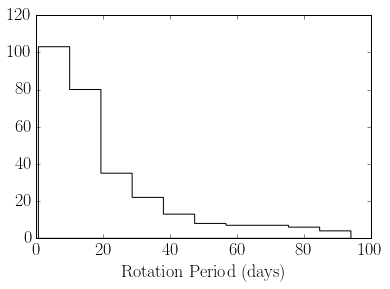

In [258]:
plt.hist(periods, 10, histtype="stepfilled", color="w")
plt.xlabel("$\mathrm{Rotation~Period~(days)}$")

Plot a histogram of $T_{\mathrm{eff}}$

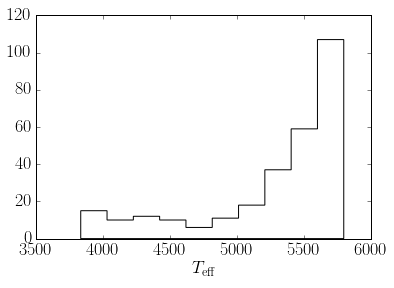

In [257]:
plt.hist(teff, 10, histtype="stepfilled", color="w")
plt.xlabel("$T_{\mathrm{eff}}$")

Plot a histogram of age.

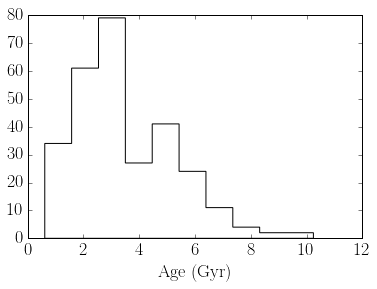

In [255]:
plt.hist(age, 10, histtype="stepfilled", color="w")
plt.xlabel("$\mathrm{Age~(Gyr)}$")